# Homework 6: Classification

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

This homework assignment is very similar to the in-class lab exercise that you completed this week.


The dataset is from the "Malicious and Benign Websites" Kaggle project at https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home (you'll need to go to that URL to get a full description of the data).

From the overview:

> The project consisted to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

Your task is to build the best classifier you can, choosing from either Random Forests or Naive Bayes classifiers (i.e. no XGBoost, SVM, Logistic Regression, etc.).

We have provided training and testing datasets for you to use, that way you're not going to introduce the problem of random sampling when you test your models.

1. Build both Random Forest (10 points) and Naive Bayes (10 points) classifiers to predict the TYPE variable.

2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points).

3. Tune your Random Forest model by varying hyperparamters (15 points).

3. Experiment with setting the appropriate values for *priors* in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points).

4. Report the most important feature(s) based on your Random Forest classifier (10 points).

5. Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results.  You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)


In [1]:
MY_UNIQNAME = 'yuqin'

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Filter all warnings.
import warnings
warnings.filterwarnings('ignore')

/Users/Apple/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Prepare the dataset
1. Non-number features can work as input
2. get an overview of the features and label
3. Deal with null value
4. Seperate classes
5. Scale the value of each feature - (I encountered the error like out of range)

In [3]:
df_mb = pd.read_csv('malicious_and_benign.csv')
df_mb_test = pd.read_csv('malicious_and_benign_test.csv')
# get an overview of the features and label
# df_mb.head(5)

In [4]:
# Deal with the null value reference: https://www.kaggle.com/shikhar14cse/learning-model-using-sklearn

# print(df_mb.isnull().sum().sum())
no_null = 812
avg = df_mb.CONTENT_LENGTH.sum() / (len(df_mb) - 812)
df_mb.loc[df_mb['CONTENT_LENGTH'].isnull(), 'CONTENT_LENGTH'] = avg
df_mb = df_mb.dropna()

# print(df_mb_test.isnull().sum().sum())
avg = df_mb_test.CONTENT_LENGTH.sum() / (len(df_mb_test) - 165)
df_mb_test.loc[df_mb_test['CONTENT_LENGTH'].isnull(), 'CONTENT_LENGTH'] = avg
df_mb_test = df_mb_test.dropna()

In [5]:
del df_mb['URL']
del df_mb['WHOIS_REGDATE']
del df_mb['WHOIS_UPDATED_DATE']
del df_mb_test['URL']
del df_mb_test['WHOIS_REGDATE']
del df_mb_test['WHOIS_UPDATED_DATE']

In [6]:
# for the failure of converting string to float
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df_mb['CHARSET'] = le.fit_transform(df_mb['CHARSET'])
df_mb['SERVER'] = le.fit_transform(df_mb['SERVER'])
df_mb['WHOIS_COUNTRY'] = le.fit_transform(df_mb['WHOIS_COUNTRY'])
df_mb['WHOIS_STATEPRO'] = le.fit_transform(df_mb['WHOIS_STATEPRO'])

df_mb_test['CHARSET'] = le.fit_transform(df_mb_test['CHARSET'])
df_mb_test['SERVER'] = le.fit_transform(df_mb_test['SERVER'])
df_mb_test['WHOIS_COUNTRY'] = le.fit_transform(df_mb_test['WHOIS_COUNTRY'])
df_mb_test['WHOIS_STATEPRO'] = le.fit_transform(df_mb_test['WHOIS_STATEPRO'])

In [7]:
# get the dataframe columns in the format of array
columns = df_mb.columns.values

# Scale the value of each feature - (I encountered the error like out of range)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_mb_scaled = scaler.fit_transform(df_mb.ix[:,:-1])
df_mb_scaled = pd.DataFrame(data=df_mb_scaled,columns=columns[:-1])
df_mb_scaled['Type'] = df_mb['Type']

# print(df_mb_scaled.isnull().sum().sum())
avg = df_mb_scaled.CONTENT_LENGTH.sum() / (len(df_mb_scaled))
df_mb_scaled.loc[df_mb_scaled['CONTENT_LENGTH'].isnull(), 'CONTENT_LENGTH'] = avg
df_mb_scaled = df_mb_scaled.dropna()

df_mb_test_scaled = scaler.fit_transform(df_mb_test.ix[:,:-1])
df_mb_test_scaled = pd.DataFrame(data=df_mb_test_scaled,columns=columns[:-1])
df_mb_test_scaled['Type'] = df_mb_test['Type']
# print(df_mb_test_scaled.isnull().sum().sum())

## Train the Classifer for the dataset
1. train_test_split
2. pick classifers
3. define the specific objective, classes and features for each classifer
4. train the model

In [8]:
df_mb_train,df_mb_validation = train_test_split(df_mb_scaled, test_size=0.3)

### 1️⃣ Random Forest
* Objective: predict which type a website belongs to - Malicious or Benign.
* Possible classes: "Malicious" = 1, "Benign" = 2
* Features: all features
* Process: 
    * changing the number of "folds" in your cross-validator
    * report the most important features
    * Find the best parameters

#### 1. changing the number of "folds" in your cross-validator and report the most important features

In [20]:
# fold = 10
rf_model_10 = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model_10.fit(df_mb_train.ix[:,:-1],df_mb_train.Type)

print("For validation dataset: ", rf_model_10.score(df_mb_validation.ix[:,:-1], df_mb_validation.Type))
print("For test dataset: ", rf_model_10.score(df_mb_test_scaled.ix[:,:-1], df_mb_test_scaled.Type))

For validation dataset:  0.9363295880149812
For test dataset:  0.8683473389355743


In [17]:
# fold = 100
rf_model_100 = skens.RandomForestClassifier(n_estimators=100,oob_score=True, criterion='entropy')
rf_model_100.fit(df_mb_train.ix[:,:-1],df_mb_train.Type)

print("For validation dataset: ", rf_model_100.score(df_mb_validation.ix[:,:-1], df_mb_validation.Type))
print("For test dataset: ", rf_model_100.score(df_mb_test_scaled.ix[:,:-1], df_mb_test_scaled.Type))

For validation dataset:  0.9438202247191011
For test dataset:  0.8627450980392157


In [18]:
# fold = 50
rf_model_50 = skens.RandomForestClassifier(n_estimators=50,oob_score=True, criterion='entropy')
rf_model_50.fit(df_mb_train.ix[:,:-1],df_mb_train.Type)

print("For validation dataset: ", rf_model_50.score(df_mb_validation.ix[:,:-1], df_mb_validation.Type))
print("For test dataset: ", rf_model_50.score(df_mb_test_scaled.ix[:,:-1], df_mb_test_scaled.Type))

For validation dataset:  0.9363295880149812
For test dataset:  0.8599439775910365


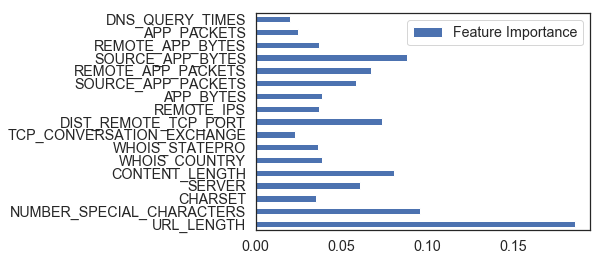

In [24]:
feat_importance_10 = rf_model_10.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=df_mb_train.columns[:-1]).plot(kind='barh')

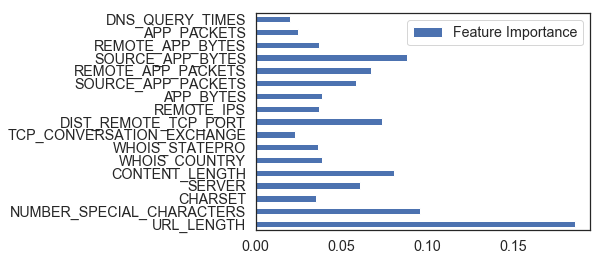

In [22]:
feat_importance_100 = rf_model_100.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=df_mb_train.columns[:-1]).plot(kind='barh')

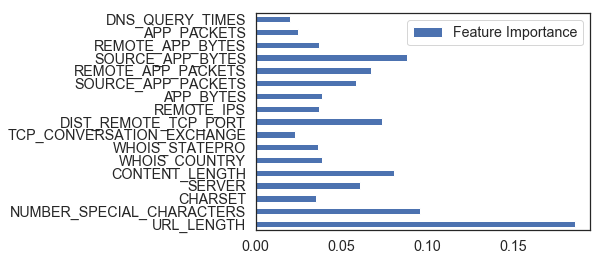

In [23]:
feat_importance_100 = rf_model_50.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=df_mb_train.columns[:-1]).plot(kind='barh')

### Explain:
Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points).

Report the most important feature(s) based on your Random Forest classifier (10 points).

* When changing the folds to 10, 50, 100, I found there is no change on the most important feature, which is URL_LENGTH.
* I have splited one validation dataset for selecting the best models while keeping the test dataset seperate to reduce overfitting.
* I found that the accuracy score for the validation dataset is high while the score is relatively low for the test dataset. For validation dataset:  0.9438202247191011, For test dataset:  0.8627450980392157. 
* This may indicate potential overfitting model.

#### 2. Find the best parameters

Tune your Random Forest model by varying hyperparamters (15 points).

In [27]:
# cross-validation by GridSearch
from sklearn.model_selection import GridSearchCV
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,55,60,65,70,75,80],
                 'max_depth': range(1,30)
             }
rf_model = skens.RandomForestClassifier()
grid_clf = GridSearchCV(rf_model, param_grid, cv=10)
grid_clf.fit(df_mb_train.ix[:,:-1],df_mb_train.Type)
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)
print(grid_clf.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=19, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'max_depth': 19, 'n_estimators': 20}
0.9283990345937249


In [73]:
rf_model_best = skens.RandomForestClassifier(max_depth = 19, n_estimators=20,oob_score=True, criterion='entropy')
rf_model_best.fit(df_mb_train.ix[:,:-1],df_mb_train.Type)

print("For validation dataset: ", rf_model_best.score(df_mb_validation.ix[:,:-1], df_mb_validation.Type))
print("For test dataset: ", rf_model_best.score(df_mb_test_scaled.ix[:,:-1], df_mb_test_scaled.Type))

For validation dataset:  0.9419475655430711
For test dataset:  0.8599439775910365


### 2️⃣Naive Bayes
Experiment with setting the appropriate values for priors in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points).

Build Naive Bayes classifiers to predict the TYPE variable. (10 points) 

* My Goal: predict the TYPE of the website. 
* What features I gonna use?
* What class I want to predict?


#### 1. If I used all features to do the prediction. The result is awful

In [31]:
# train the model
gnb_model = sknb.GaussianNB()
gnb_model.fit(df_mb_train.ix[:,:-1],df_mb_train.Type)
print("For validation dataset: ", gnb_model.score(df_mb_validation.ix[:,:-1], df_mb_validation.Type))
print("For test dataset: ", gnb_model.score(df_mb_test_scaled.ix[:,:-1], df_mb_test_scaled.Type))

For validation dataset:  0.5917602996254682
For test dataset:  0.7815126050420168


#### 2. If I use the most important feature to do the prediction? much better! worse than Random tree, but close.

In [49]:
# most important feature is URL_Length
gnb_model_mf = sknb.GaussianNB()
gnb_model_mf.fit(df_mb_train[['URL_LENGTH']],df_mb_train.Type)
print("For validation dataset: ", gnb_model_mf.score(df_mb_validation[['URL_LENGTH']], df_mb_validation.Type))
print("For test dataset: ", gnb_model_mf.score(df_mb_test_scaled[['URL_LENGTH']], df_mb_test_scaled.Type))

For validation dataset:  0.8782771535580525
For test dataset:  0.8515406162464986


#### 3. If I use the top 2 or top 4 or top 6 important features to do the prediction? Not better than the result of the top one feature's prediction. Interesting!

In [42]:
# Top 2 important features are SOURCE_APP_BYTES and URL_LENGTH
toptwo = ['URL_LENGTH','SOURCE_APP_BYTES']
gnb_model_t2 = sknb.GaussianNB()
gnb_model_t2.fit(df_mb_train[toptwo],df_mb_train.Type)
print("For validation dataset: ", gnb_model_t2.score(df_mb_validation[toptwo], df_mb_validation.Type))
print("For test dataset: ", gnb_model_t2.score(df_mb_test_scaled[toptwo], df_mb_test_scaled.Type))

For validation dataset:  0.8707865168539326
For test dataset:  0.8319327731092437


In [38]:
columns

array(['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO',
       'TCP_CONVERSATION_EXCHANGE', 'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS',
       'APP_BYTES', 'SOURCE_APP_PACKETS', 'REMOTE_APP_PACKETS',
       'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES', 'APP_PACKETS',
       'DNS_QUERY_TIMES', 'Type'], dtype=object)

In [43]:
# Top 4 important features are SOURCE_APP_BYTES and URL_LENGTH
topfour = ['URL_LENGTH', 'SOURCE_APP_BYTES', 'NUMBER_SPECIAL_CHARACTERS', 'CONTENT_LENGTH']
gnb_model_t4 = sknb.GaussianNB()
gnb_model_t4.fit(df_mb_train[topfour],df_mb_train.Type)
print("For validation dataset: ", gnb_model_t4.score(df_mb_validation[topfour], df_mb_validation.Type))
print("For test dataset: ", gnb_model_t4.score(df_mb_test_scaled[topfour], df_mb_test_scaled.Type))

For validation dataset:  0.8576779026217228
For test dataset:  0.7563025210084033


In [50]:
# Top 6 important features are SOURCE_APP_BYTES and URL_LENGTH
topsix = ['URL_LENGTH', 'SOURCE_APP_BYTES', 'NUMBER_SPECIAL_CHARACTERS', 'CONTENT_LENGTH','DIST_REMOTE_TCP_PORT','REMOTE_APP_PACKETS']
gnb_model_t6 = sknb.GaussianNB()
gnb_model_t6.fit(df_mb_train[topsix],df_mb_train.Type)
print("For validation dataset: ", gnb_model_t6.score(df_mb_validation[topsix], df_mb_validation.Type))
print("For test dataset: ", gnb_model_t6.score(df_mb_test_scaled[topsix], df_mb_test_scaled.Type))


For validation dataset:  0.848314606741573
For test dataset:  0.7450980392156863


### Summarize:
Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results. You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)

* I have splited one validation dataset for selecting the best models while keeping the test dataset seperate to reduce overfitting.
* Best models:
    * The best random forest classifer I got is the model with 19 max_depth and 20 n_ estimators, which got the accuracy score for validation dataset:  0.9438202247191011 and for test dataset 0.8711484593837535.
    * The best naive bayes classifer I got is the model trained by the most important feature - 'URL_LENGTH'. I found an interesting thing is that the more features I used to train the model, the result became worse or not better. 
    
* From the results of the accuracy scores, we can find that random forest classifier has better performance than the Naive Bayes Classifer:
    * However, random forest classifier has the potential to be overfitting because the accuracy score for the validation dataset is high while the score is relatively low for the test dataset. For validation dataset: 0.9438202247191011, For test dataset: 0.8627450980392157. The best naive bayes classifier tends to give me a stable prediction because it got 0.878 accuracy score for the validation dataset when the score for test dataset is 0.851, quite close. 
    
* Explain: (do some research about websites and the internet protocols)
    * To understand the relationship between the features and labels. I digged deeper about the mechnisms of how we access to a website and how this website could affect my computer. 
    * Basically, we access a website through its Uniform Resource Locators (URLs), which consists of the following standard syntax:
    <protocol>://<hostname><path>
    * For the protocol, HTTP is the most popular one.
    * Path indicates how to locate the files and access to it. In the path, we might use many tokens such as slashes, dots, and dashes, which shows how the site is organized. Based one the paper *Learning to Detect Malicious URLs* "criminals sometimes obscure path tokens to avoid scrutiny, or they may deliberately construct tokens to mimic the appearance of a legitimate site, as in the case of phishing." Thus the features related with "path" might be not effective to predict the malicious website.
    * The above characteristics explain a little bit about why, in the machine learning process, the following four features are top four important: 
        ['URL_LENGTH', 'SOURCE_APP_BYTES', 'NUMBER_SPECIAL_CHARACTERS', 'CONTENT_LENGTH']
        * URL_LENGTH: it is the number of characters in the URL. 
        * NUMBER_SPECIAL_CHARACTERS: it is number of special characters identified in the URL, such as, “/”, “%”, “#”, “&”, “. “, “=”
        * CONTENT_LENGTH: it represents the content size of the HTTP header.
        * APP_BYTES: this is the number of bytes transfered, which may be related to how many information you can get access through visting this website and these information may have impact on my computer. 
    
* Improvement:
    * One improvement I can do is about feature engineering. What features we can use to descirbe the URL and a website might need to be reconsider, which might be beyond what I'm capable of. But for my assignment, I would improve the result by tring to only extract important features to train different random tree classifiers in order to reduce the overfitting. What's more, I can do some model regulations to avoid the situation when the accuracy score for the validation set is high while the score of the test set is relatively normal. 
    * I also think of trying out other classifiers, for example, Logistic Regression classifier which is suitable for the binary labeled dataset or SVM. 

Reference: 
* Learning to Detect Malicious URLs written by JUSTIN MA, University of California, Berkeley LAWRENCE K. SAUL, STEFAN SAVAGE and GEOFFREY M. VOELKER, University of California, San Diego
* https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home